![surprise](https://github.com/longfengpili/Machine-Learning-with-Python/blob/master/surprise.png?raw=true)

In [1]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor #normalpredictor,根据训练集的分布特征随机给出一个预测值
from surprise import KNNBasic #基础班协同过滤,最基础的协同过滤
from surprise import KNNWithMeans #均值协同过滤,将每个用户评分的均值考虑在内的协同过滤实现
from surprise import KNNWithZScore #
from surprise import KNNBaseline #协同过滤baseline,	考虑基线评级的协同过滤
from surprise import SVD #SVD,SVD实现
from surprise import BaselineOnly #baselineOnly,给定用户和Item，给出基于baseline的估计值
from surprise import SVDpp #SVD++,SVD++，即LFM+SVD
from surprise import NMF #NMF,基于矩阵分解的协同过滤
from surprise import SlopeOne #一个简单但精确的协同过滤算法
from surprise import CoClustering #基于协同聚类的协同过滤算法
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
user = pd.read_csv('e:/data/bx_dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1",header=None)
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('e:/data/bx_dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

In [3]:
user.head()

,userID,Location,Age
0,1,"nyc, new york, usa",\N
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",\N
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",\N


In [4]:
rating.head()

,userID,ISBN,bookRating
0,276726,0155061224,5
1,276727,0446520802,0
2,276729,052165615X,3
3,276729,0521795028,6
4,276733,2080674722,0


In [5]:
df = pd.merge(user, rating, on='userID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)

In [6]:
df.head()

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0


In [7]:
df.shape

(1149779, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149779 entries, 0 to 1149778
Data columns (total 3 columns):
userID        1149779 non-null int64
ISBN          1149779 non-null object
bookRating    1149779 non-null int64
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


In [9]:
df.describe().round(2)

,userID,bookRating
count,1149779.00,1149779.00
mean,140386.28,2.87
std,80562.21,3.85
min,2.00,0.00
25%,70345.00,0.00
50%,141010.00,0.00
75%,211028.00,7.00
max,278854.00,10.00


## EDA

### Ratings Distribution

10     78610
9      67541
8     103736
7      76457
6      36924
5      50974
4       8904
3       5996
2       2759
1       1770
0     716108
Name: bookRating, dtype: int64

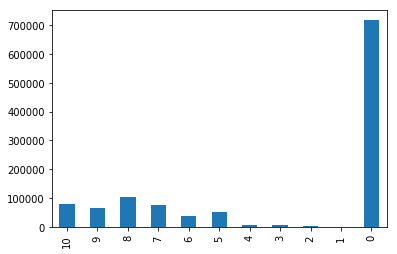

In [10]:
data = df['bookRating'].value_counts().sort_index(ascending=False)
data
data.plot(kind='bar')

We can see that over 62% of all ratings in the data are 0, and very few ratings are 1 or 2, or 3, low rating books mean they are generally really bad.

### Ratings Distribution By Book

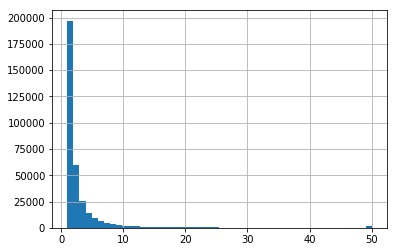

In [11]:
# Number of ratings per book
data = df.groupby('ISBN')['bookRating'].count().clip(upper=50)
data.hist(bins=50)

In [12]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

,ISBN,bookRating
247408,0971880107,2502
47371,0316666343,1295
83359,0385504209,883
9637,0060928336,732
41007,0312195516,723
101670,044023722X,647
166705,0679781587,639
28153,0142001740,615
166434,067976402X,614
153620,0671027360,586


Most of the books received less than 5 ratings, and very few books have many ratings, although the most rated book has received 2,502 ratings.

### Ratings Distribution By User

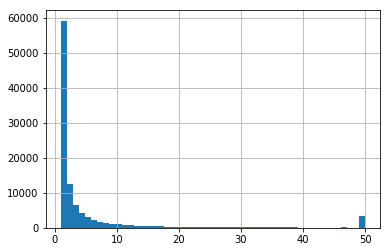

In [13]:
# Number of ratings per user
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

data.hist(bins=50)

In [14]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

,userID,bookRating
4213,11676,13602
74815,198711,7550
58113,153662,6109
37356,98391,5891
13576,35859,5850
80185,212898,4785
105110,278418,4533
28884,76352,3367
42037,110973,3100
88584,235105,3067


Most of the users gave less than 5 ratings, and very few users gave many ratings, although the most productive user have given 13,602 ratings.

I'm sure you have noticed that the above two charts share the same distribution. The number of ratings per movie and the number of ratings per user decay exponentially.

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users.

In [15]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149779, 3)
The new data frame shape:	(140516, 3)


## Surprise

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [16]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

With the Surprise library, we will benchmark the following algorithms

### Basic algorithms

#### NormalPredictor

* NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

#### BaselineOnly

* BasiclineOnly algorithm predicts the baseline estimate for given user and item.

### k-NN algorithms

#### KNNBasic

* KNNBasic is a basic collaborative filtering algorithm.

#### KNNWithMeans

* KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

#### KNNWithZScore

* KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

#### KNNBaseline

* KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms

#### SVD

* SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

#### SVDpp

* The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

#### NMF

* NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

### Slope One

* Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

### Co-clustering

* Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)


We use rmse as our accuracy metric for the predictions.

In [17]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=1,n_jobs=-1)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print('=='*50)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    3.5363  3.5483  3.5506  3.5450  0.0063  
Fit time          4.53    4.60    4.52    4.55    0.04    
Test time         0.29    0.25    0.25    0.26    0.02    
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    3.7727  3.7877  3.7922  3.7842  0.0083  
Fit time          107.41  107.26  107.22  107.29  0.08    
Test time         3.52    3.50    3.40    3.47    0.05    
Evaluating RMSE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    3.4654  3.4719  3.4833  3.4736  0.0074  
Fit time          0.64    0.61    0.57    0.60    0.03    
Test time         3.04    2.97    3.04    3.02    0.04    
Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    3.8294  3.86

In [18]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

,fit_time,test_rmse,test_time
Algorithm,,,
BaselineOnly,0.039570,3.380003,0.196491
CoClustering,1.368662,3.469432,0.205128
SlopeOne,0.604059,3.473555,3.016944
KNNWithMeans,0.586098,3.491864,4.238485
KNNBaseline,0.587421,3.497620,4.894913
KNNWithZScore,0.669209,3.503925,4.544250
SVD,4.549837,3.545044,0.260645
KNNBasic,0.582442,3.728743,3.449788
SVDpp,107.293950,3.784184,3.472045


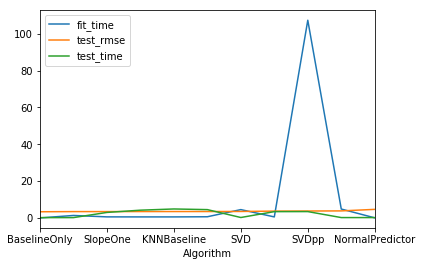

In [19]:
surprise_results
surprise_results.plot(kind='line')

BaselineOnly algorithm gave us the best rmse, therefore, we will proceed further with BaselineOnly and use Alternating Least Squares (ALS).

In [20]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=1)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    3.3666  3.3743  3.3726  3.3712  0.0033  
Fit time          0.11    0.12    0.13    0.12    0.01    
Test time         0.23    0.24    0.22    0.23    0.01    


{'fit_time': (0.10571885108947754, 0.12464404106140137, 0.12765884399414062),
 'test_rmse': array([3.36659646, 3.37433886, 3.37256415]),
 'test_time': (0.2293846607208252, 0.2363874912261963, 0.22040987014770508)}

We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [21]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.3507


3.3506589913326024

In [22]:
predictions[:3]

[Prediction(uid=178093, iid='044011585X', r_ui=2.0, est=1.8410864742893618, details={'was_impossible': False}),
 Prediction(uid=190459, iid='0399141464', r_ui=0.0, est=1.3652015234192167, details={'was_impossible': False}),
 Prediction(uid=26535, iid='0786881852', r_ui=0.0, est=1.5683765149453, details={'was_impossible': False})]

In [23]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.

In [24]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [25]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,178093,044011585X,2.0,1.841086,{'was_impossible': False},4,41,0.158914
1,190459,0399141464,0.0,1.365202,{'was_impossible': False},75,33,1.365202
2,26535,0786881852,0.0,1.568377,{'was_impossible': False},23,92,1.568377
3,240035,0345447840,0.0,1.399714,{'was_impossible': False},71,57,1.399714
4,254,0452282152,0.0,2.932837,{'was_impossible': False},56,178,2.932837


In [26]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [27]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
28770,261105,0971880107,0.0,0.0,{'was_impossible': False},19,631,0.0
3380,268330,0345353145,0.0,0.0,{'was_impossible': False},126,155,0.0
31529,149084,1573229083,0.0,0.0,{'was_impossible': False},52,21,0.0
15064,269566,044023574X,0.0,0.0,{'was_impossible': False},273,29,0.0
33950,73394,1573228583,0.0,0.0,{'was_impossible': False},224,27,0.0
3392,269566,0425134350,0.0,0.0,{'was_impossible': False},273,31,0.0
31516,264317,0345420748,0.0,0.0,{'was_impossible': False},100,25,0.0
23562,182053,0380731851,0.0,0.0,{'was_impossible': False},46,130,0.0
33957,38229,0971880107,0.0,0.0,{'was_impossible': False},12,631,0.0
19225,203968,0425092917,0.0,0.0,{'was_impossible': False},87,56,0.0


The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 26 to 146, they are not really small, meaning that significant number of users have rated the target book.

In [28]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
23479,154992,0743411331,10.0,0.027687,{'was_impossible': False},48,23,9.972313
31596,36836,0345334531,10.0,0.000000,{'was_impossible': False},161,36,10.000000
32442,26544,055358264X,10.0,0.000000,{'was_impossible': False},194,47,10.000000
10295,124489,0452269652,10.0,0.000000,{'was_impossible': False},50,20,10.000000
13131,182442,0679433740,10.0,0.000000,{'was_impossible': False},39,33,10.000000
7740,201017,1401088945,10.0,0.000000,{'was_impossible': False},63,48,10.000000
19619,24921,0440236665,10.0,0.000000,{'was_impossible': False},94,28,10.000000
1358,55548,0553278398,10.0,0.000000,{'was_impossible': False},129,30,10.000000
33791,253106,0316781266,10.0,0.000000,{'was_impossible': False},32,80,10.000000
34038,238120,0385413041,10.0,0.000000,{'was_impossible': False},322,29,10.000000


The worst predictions look pretty surprise. Let's look in more details of the last one ISBN "055358264X", the book was rated by 47 users, user "26544" rated 10, our BaselineOnly algorithm predicts 0.

In [29]:
df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].describe()

count    60.000000
mean      1.283333
std       2.969287
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.000000
Name: bookRating, dtype: float64

Text(0.5,0,'rating')

Text(0,0.5,'Number of ratings')

Text(0.5,1,'Number of ratings book ISBN 055358264X has received')

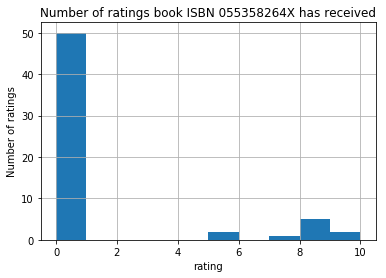

In [30]:
df_new.loc[df_new['ISBN'] == '055358264X']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')

It turns out, most of the ratings this book received was "0", in another word, most of the users in the data rated this book "0", only very few users rated "10". Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.

In [31]:
df_predictiion = df[df.uid == 16966].sort_values(by='rui',ascending=False)
df_predictiion
df_new[(df_new.userID == 16966) & (df_new.ISBN.isin(df_predictiion.iid))].sort_values(by=['bookRating'],ascending=False)
df_new[(df_new.userID == 16966)].sort_values(by=['bookRating'],ascending=False)

,uid,iid,rui,est,details,Iu,Ui,err
491,16966,0765342987,9.0,2.938094,{'was_impossible': False},14,23,6.061906
132,16966,0425181464,8.0,1.875910,{'was_impossible': False},14,43,6.124090
5947,16966,0312979096,7.0,2.730256,{'was_impossible': False},14,43,4.269744
24816,16966,0553582364,6.0,2.144700,{'was_impossible': False},14,23,3.855300
10215,16966,0345353145,0.0,2.029785,{'was_impossible': False},14,155,2.029785
11055,16966,0345354621,0.0,1.867577,{'was_impossible': False},14,38,1.867577
13147,16966,0345378490,0.0,1.918046,{'was_impossible': False},14,128,1.918046
22429,16966,0316096199,0.0,3.204485,{'was_impossible': False},14,143,3.204485
22794,16966,0440214041,0.0,2.222480,{'was_impossible': False},14,244,2.222480
26316,16966,0671001795,0.0,2.692342,{'was_impossible': False},14,137,2.692342


,userID,ISBN,bookRating
72807,16966,0765342987,9
72580,16966,0425181464,8
72400,16966,0312979096,7
72721,16966,0553582364,6
72401,16966,0316096199,0
72409,16966,0345353145,0
72410,16966,0345354621,0
72412,16966,0345378490,0
72588,16966,0440214041,0
72628,16966,0446604232,0


,userID,ISBN,bookRating
72867,16966,0886777844,10
72399,16966,0312974256,9
72807,16966,0765342987,9
72376,16966,0140143505,9
72580,16966,0425181464,8
72400,16966,0312979096,7
72418,16966,0345423402,6
72721,16966,0553582364,6
72711,16966,0553569910,3
72403,16966,0330262130,0
